In [36]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from model_evaluate import evaluate_model

In [37]:
import sys
!{sys.executable} -m pip install xgboost


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [38]:
# Step 2: Load the saved training and testing data
train_data = pd.read_csv("train_multi_output.csv")
test_data = pd.read_csv("test_multi_output.csv")

# Separate features and targets
X_train = train_data[['Season', 'Day_of_the_week', 'DHI', 'DNI', 'GHI', 'Wind_speed', 'Humidity', 'Temperature']]
y_train = train_data[['PV_production', 'Wind_production']]

X_test = test_data[['Season', 'Day_of_the_week', 'DHI', 'DNI', 'GHI', 'Wind_speed', 'Humidity', 'Temperature']]
y_test = test_data[['PV_production', 'Wind_production']]

In [ ]:
# Step 3: Initialize and train the XGBoost model
xgb_base_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,      
    subsample=0.8,  
    colsample_bytree=0.8,  
    random_state=42,
    objective='reg:squarederror',
    n_jobs=-1
)

xgb_model = MultiOutputRegressor(xgb_base_model)
xgb_model.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.05, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=300, n_jobs=-1,
                                            num_parallel_tree=None, ...))

In [40]:
# Step 4: Make predictions
y_pred = xgb_model.predict(X_test)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
XGBOOST MODEL EVALUATION
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
--- XGBoost - PV Production ---
MAE: 318.148
MSE: 403243.681
RMSE: 635.015
R²: 0.971
Adjusted R²: 0.971
Explained Variance: 0.971
Sample Size: 11664
Visualization Sample: 5,000 points


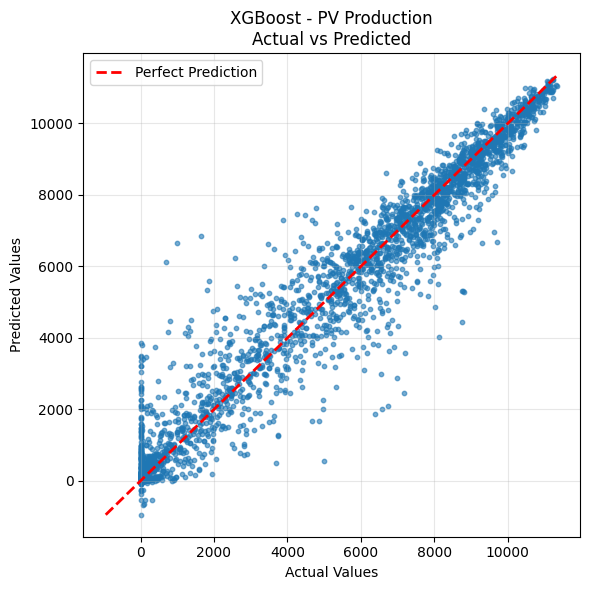

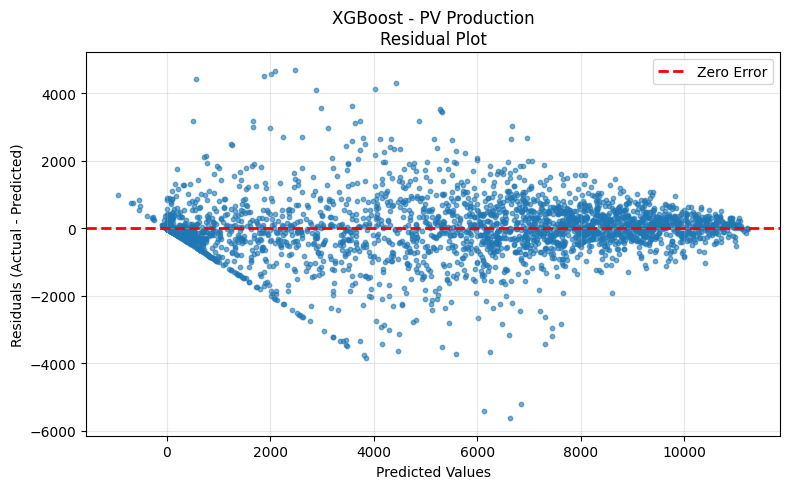

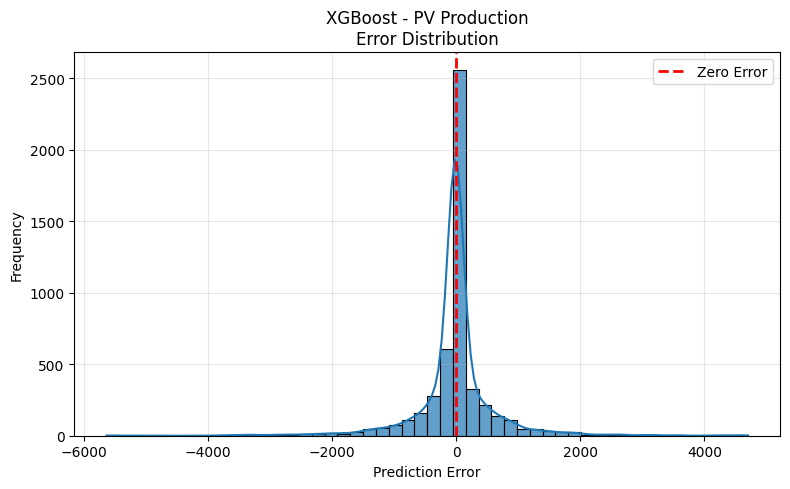

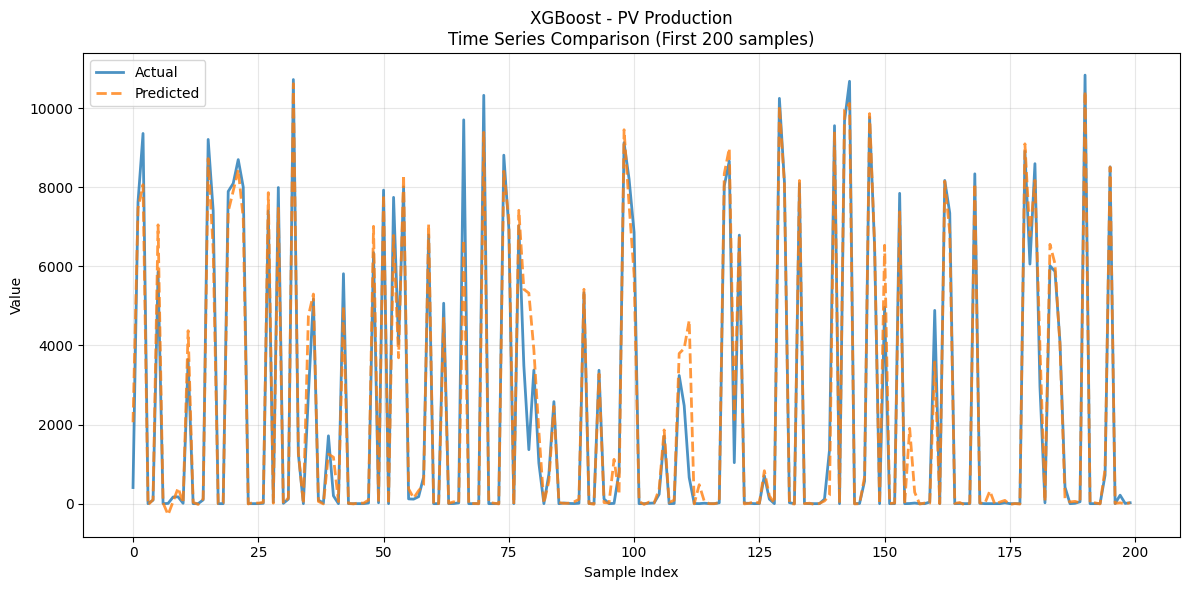

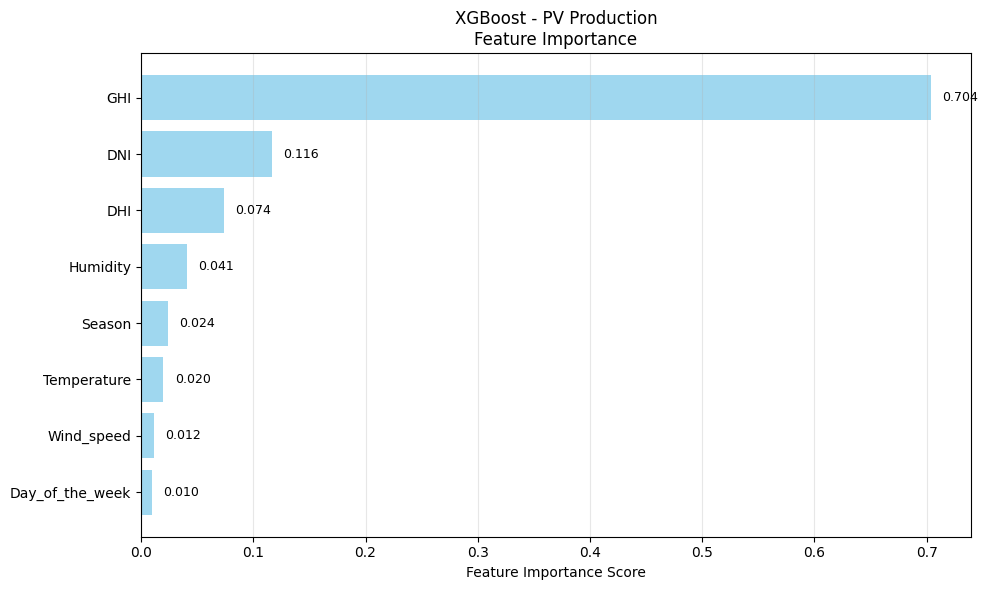


Top Features for PV Production:
           Feature  Importance
4              GHI    0.703969
3              DNI    0.116293
2              DHI    0.073680
6         Humidity    0.040743
0           Season    0.023799
7      Temperature    0.019944
5       Wind_speed    0.011727
1  Day_of_the_week    0.009845
--- XGBoost - Wind Production ---
MAE: 348.552
MSE: 230045.326
RMSE: 479.630
R²: 0.837
Adjusted R²: 0.837
Explained Variance: 0.837
Sample Size: 11664
Visualization Sample: 5,000 points


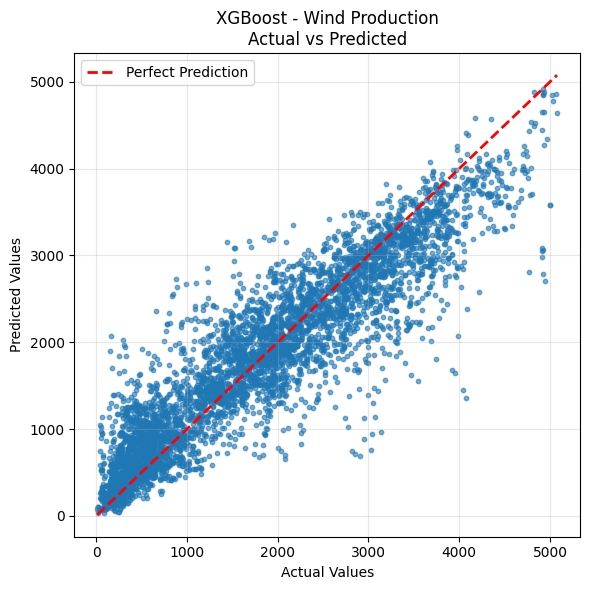

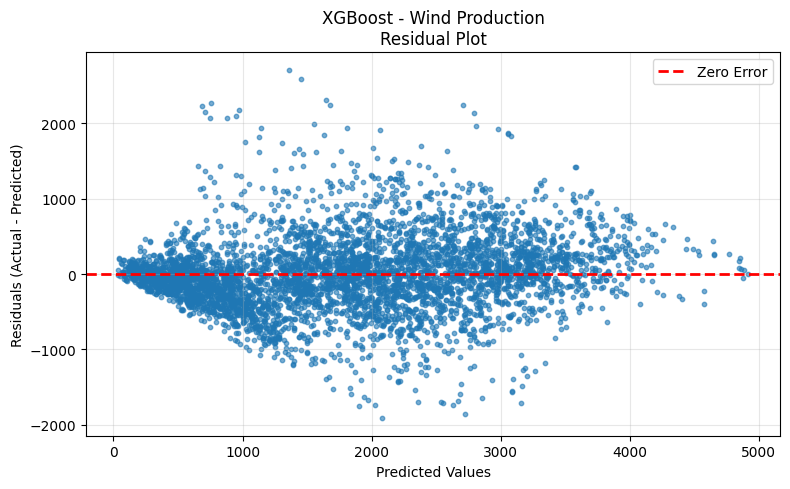

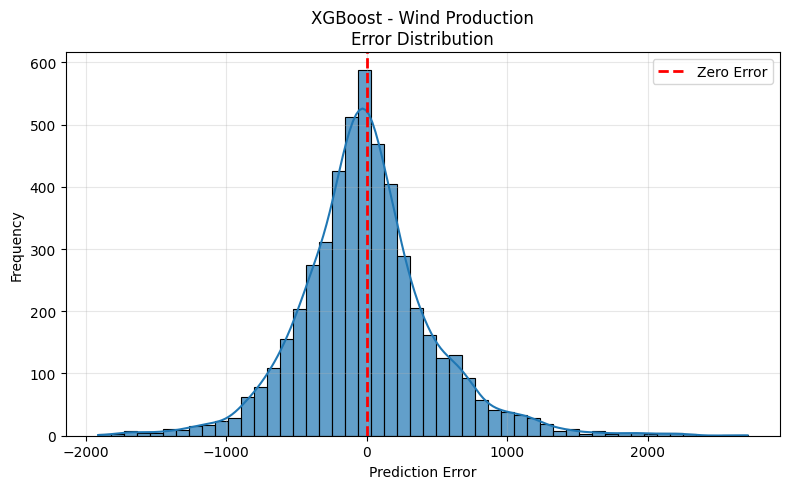

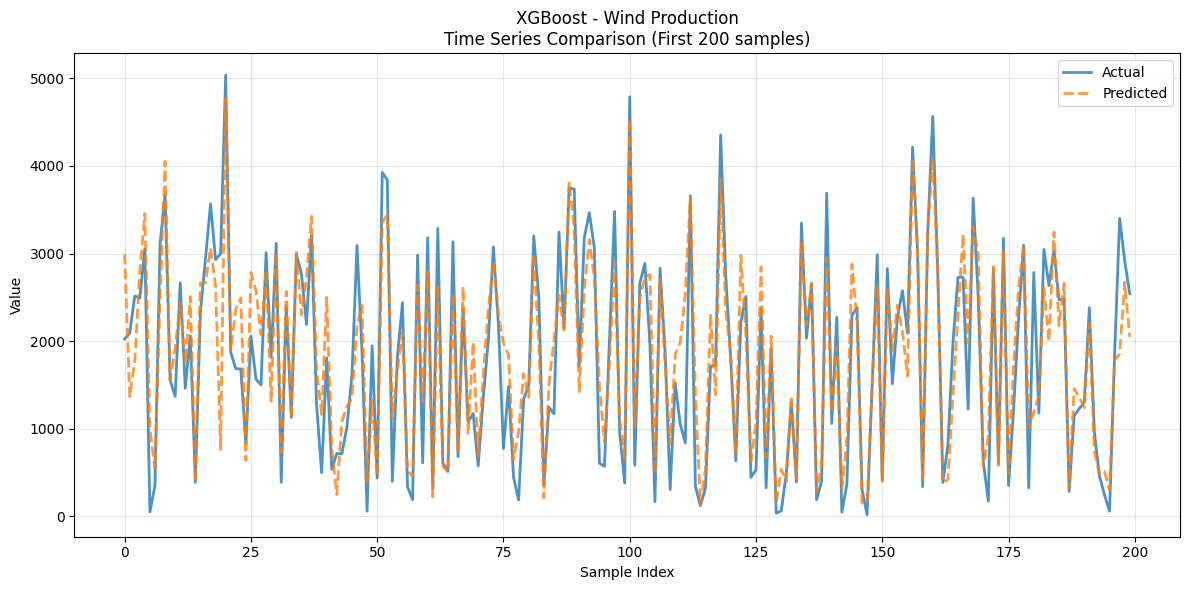

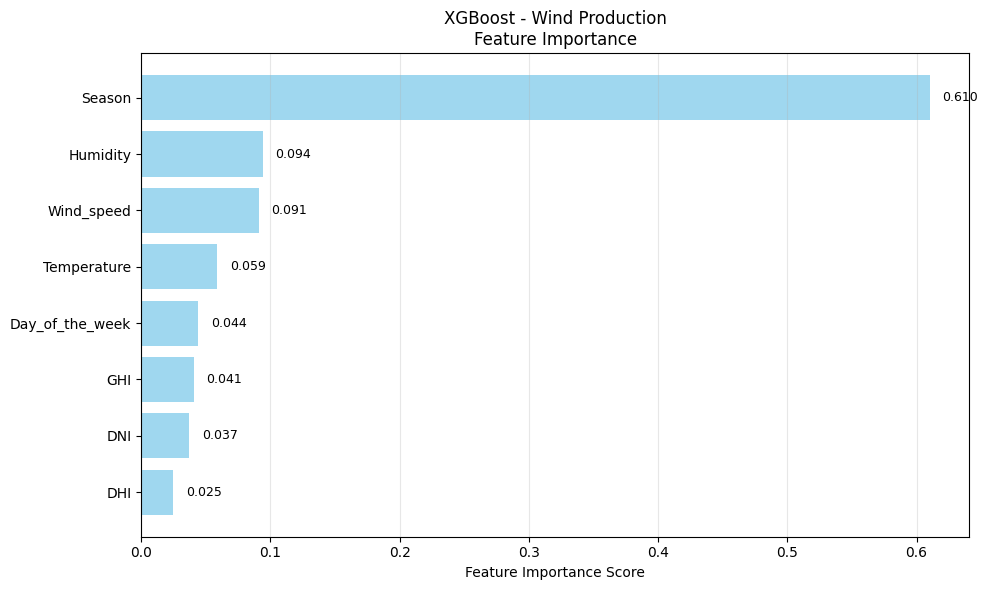


Top Features for Wind Production:
           Feature  Importance
0           Season    0.610143
6         Humidity    0.094054
5       Wind_speed    0.090894
7      Temperature    0.058578
1  Day_of_the_week    0.043833
4              GHI    0.040637
3              DNI    0.036951
2              DHI    0.024911


{'mae': np.float64(348.5524237040834),
 'mse': np.float64(230045.32598213927),
 'rmse': np.float64(479.63040560637864),
 'r2': 0.8373229503631592,
 'adj_r2': 0.8372112887246268,
 'explained_variance': 0.8373232189109884}

In [41]:
# Step 5: Evaluate Model Performance
print("~" * 70)
print("XGBOOST MODEL EVALUATION")
print("~" * 70)

# PV Production Evaluation
evaluate_model(
    y_true=y_test['PV_production'],
    y_pred=y_pred[:, 0],
    model_name="XGBoost",
    target_name="PV Production",
    feature_names=X_train.columns,
    rf_model=xgb_model.estimators_[0]  
)

# Wind Production Evaluation
evaluate_model(
    y_true=y_test['Wind_production'],
    y_pred=y_pred[:, 1],
    model_name="XGBoost",
    target_name="Wind Production",
    feature_names=X_train.columns,
    rf_model=xgb_model.estimators_[1]
)

In [42]:
# Step 6: Print Overall Results
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

r2_pv = r2_score(y_test['PV_production'], y_pred[:, 0])
r2_wind = r2_score(y_test['Wind_production'], y_pred[:, 1])
mae_pv = mean_absolute_error(y_test['PV_production'], y_pred[:, 0])
mae_wind = mean_absolute_error(y_test['Wind_production'], y_pred[:, 1])

print("\nFinal XGBoost Results Summary:")
print(f"PV Production -> R²: {r2_pv:.4f}, MAE: {mae_pv:.4f}")
print(f"Wind Production -> R²: {r2_wind:.4f}, MAE: {mae_wind:.4f}")
print("~" * 70)


Final XGBoost Results Summary:
PV Production -> R²: 0.9707, MAE: 318.1482
Wind Production -> R²: 0.8373, MAE: 348.5524
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
